In [162]:
import pandas as pd
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn as skl
from sklearn import metrics
from sklearn.cluster._k_means_lloyd import lloyd_iter_chunked_dense as lloyd_iter
from threadpoolctl import threadpool_limits
from sklearn.cluster._k_means_fast import _inertia_dense as _inertia

In [2]:
def readfile(file="menu.csv"):
    return pd.read_csv(file)

In [3]:
menu=readfile()

In [4]:
m=menu.drop(columns=['Category', 'Item', 'Serving Size', 'Calories from Fat',
       'Total Fat', 'Saturated Fat', 'Trans Fat', 'Cholesterol', 'Sodium', 'Carbohydrates', 'Dietary Fiber'])

In [5]:
menu.keys()

Index(['Category', 'Item', 'Serving Size', 'Calories', 'Calories from Fat',
       'Total Fat', 'Total Fat (% Daily Value)', 'Saturated Fat',
       'Saturated Fat (% Daily Value)', 'Trans Fat', 'Cholesterol',
       'Cholesterol (% Daily Value)', 'Sodium', 'Sodium (% Daily Value)',
       'Carbohydrates', 'Carbohydrates (% Daily Value)', 'Dietary Fiber',
       'Dietary Fiber (% Daily Value)', 'Sugars', 'Protein',
       'Vitamin A (% Daily Value)', 'Vitamin C (% Daily Value)',
       'Calcium (% Daily Value)', 'Iron (% Daily Value)'],
      dtype='object')

In [6]:
m.keys()

Index(['Calories', 'Total Fat (% Daily Value)',
       'Saturated Fat (% Daily Value)', 'Cholesterol (% Daily Value)',
       'Sodium (% Daily Value)', 'Carbohydrates (% Daily Value)',
       'Dietary Fiber (% Daily Value)', 'Sugars', 'Protein',
       'Vitamin A (% Daily Value)', 'Vitamin C (% Daily Value)',
       'Calcium (% Daily Value)', 'Iron (% Daily Value)'],
      dtype='object')

In [7]:
def size_to_unit(elem):
    if 'g' in elem:
        return elem.split()[-2][1:]
    if 'ml' in elem:
        return elem.split()[-2][1:]
    if 'fl' in elem:
        return elem.split()[0]
    return elem

In [8]:
sizes=[float(size_to_unit(el)) for el in menu['Serving Size']];
keys=list(filter(lambda x: '%' in x, m.keys()))
data=m.div(sizes, axis=0)
data=m.div(100, level=keys)
data['Calories']=m['Calories']/2250
data['Sugars']=m['Sugars']/30
data['Protein']=m['Protein']/51
data=data.rename(columns={"Calories": "Calories (% Daily Value)", "Sugars": "Sugars (% Daily Value)", "Protein":"Protein (% Daily Value"});

In [9]:
data.keys()

Index(['Calories (% Daily Value)', 'Total Fat (% Daily Value)',
       'Saturated Fat (% Daily Value)', 'Cholesterol (% Daily Value)',
       'Sodium (% Daily Value)', 'Carbohydrates (% Daily Value)',
       'Dietary Fiber (% Daily Value)', 'Sugars (% Daily Value)',
       'Protein (% Daily Value', 'Vitamin A (% Daily Value)',
       'Vitamin C (% Daily Value)', 'Calcium (% Daily Value)',
       'Iron (% Daily Value)'],
      dtype='object')

In [10]:
data.dtypes

Calories (% Daily Value)         float64
Total Fat (% Daily Value)        float64
Saturated Fat (% Daily Value)    float64
Cholesterol (% Daily Value)      float64
Sodium (% Daily Value)           float64
Carbohydrates (% Daily Value)    float64
Dietary Fiber (% Daily Value)    float64
Sugars (% Daily Value)           float64
Protein (% Daily Value           float64
Vitamin A (% Daily Value)        float64
Vitamin C (% Daily Value)        float64
Calcium (% Daily Value)          float64
Iron (% Daily Value)             float64
dtype: object

In [11]:
list(set(menu['Category']))

['Beef & Pork',
 'Snacks & Sides',
 'Salads',
 'Chicken & Fish',
 'Smoothies & Shakes',
 'Breakfast',
 'Coffee & Tea',
 'Beverages',
 'Desserts']

In [21]:
X=data.values

In [40]:
def train(X, init, v=False):
    kmeans = KMeans(n_clusters=6, n_init=1, max_iter=1, init=init)
    state = None
    i = 0
    ys = []
    while True:
        kmeans.fit(X)
        labels = kmeans.labels_
        centr = kmeans.cluster_centers_
        if np.array_equal(state,labels):
            break
        kmeans.init=centr
        state=labels
        inert=kmeans.inertia_
        score = metrics.davies_bouldin_score(X,labels)
        i+=1
        ys+=[score]
        if v:
            print(i, inert, score)
    if v:
        print('calculated\n\n\n')
    return ys

In [15]:
def kpp(X):
    return train(X,'k-means++')

def krand(X):
    return train(X, 'random')

def kself(X):
    return train(X, np.random.uniform(size=(6, X.shape[1])))

In [97]:
def plot_its(X, its=50):
    res = []
    max_len = 0
    for ix, alg in enumerate([kpp, krand, kself]):
        res.append([])
        for _ in range(its):
            res[ix].append(alg(X))
            max_len=max(max_len, len(res[-1][-1]))
    xs = list(range(1,max_len+1))
    for i in range(3):
        for j in range(its):
            while len(res[i][j])<max_len:
                res[i][j].append(res[i][j][-1])
    res = np.array(res, dtype=object)
    for ix, name in enumerate(['K++', 'K-Random', 'My Random']):
        plt.errorbar(xs, np.mean(np.array(res[ix]).astype(float), axis=0), np.std(np.array(res[ix]).astype(float), axis=0), label=name)
    plt.xlabel('Iterations')
    plt.ylabel('DBI score')
    plt.legend()
    plt.show()

In [121]:
def myrand(X, n_clusters, random_state):
    return np.random.uniform(size=(n_clusters,X.shape[1]))

In [132]:
def plot_ks(X, kmin=3, kmax=25, nits=10):
    ks = list(range(kmin, kmax+1))
    means = []
    stds = []
    for k in ks:
        res = []
        for _ in range(nits):
            kmeans = KMeans(n_clusters=k, init=myrand)
            kmeans.fit(X)
            labels = kmeans.labels_
            res.append(metrics.davies_bouldin_score(X, labels))
        means.append(np.mean(res))
        stds.append(np.std(res))

    plt.errorbar(ks, means, stds, label='My Random')
    plt.xlabel('K')
    plt.ylabel('DBI score')
    plt.legend()
    plt.show()

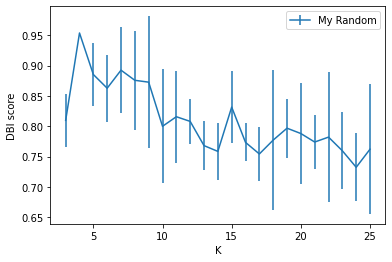

In [133]:
plot_ks(X)

In [175]:
def plot2d(X, labels, k, big=False):
    pts = PCA(2).fit_transform(X)
    c=list(range(k))
    cs = [c[labels[lab]] for lab in range(X.shape[0])]
    plt.scatter(pts[:, 0], pts[:, 1], label=labels, c=cs, s=60 if big else 10, cmap='rainbow')

In [176]:
def clusters(data, k=10):
    kmeans = KMeans(n_clusters=k, init=myrand)
    kmeans.fit(data.values)
    labels=kmeans.labels_
    centers = kmeans.cluster_centers_
    plot2d(data.values,labels,k)
    plot2d(centers, np.array(range(k)), k, True)
    plt.title('Clusters')
    plt.show()

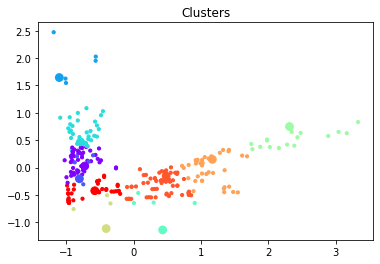

In [177]:
clusters(data)

In [277]:
def categories(data, menu, k=10):
    cats=dict( (el, ix) for ix, el in enumerate(set(menu['Category'])))
    plot2d(data.values, [cats[x] for x in menu['Category']], k)
    plt.title('Categories')
    # plt.legend()
    plt.show()

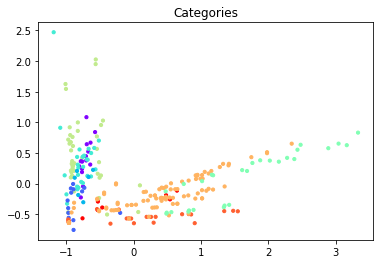

In [278]:
categories(data, menu)

In [153]:
kmean=KMeans(n_clusters=10, init=myrand)
kmean.fit(X)
# print("centers",kmean.cluster_centers_)
# print("inertia",kmean.inertia_)
print("labels", Counter(kmean.labels_))
# print("max_iter",kmean.max_iter)
# print("clusters",kmean.n_clusters)
# print("features",kmean.n_features_in_)


labels Counter({8: 66, 7: 59, 2: 56, 4: 45, 6: 16, 1: 6, 9: 6, 0: 4, 5: 1, 3: 1})


In [158]:
print('\n'.join([f"{key}: {elem}" for key, elem in {8: 66, 7: 59, 2: 56, 4: 45, 6: 16, 1: 6, 9: 6, 0: 4, 5: 1, 3: 1}.items()]))

8: 66
7: 59
2: 56
4: 45
6: 16
1: 6
9: 6
0: 4
5: 1
3: 1


In [115]:
# skl.cluster.kmeans_plusplus(data.values, n_clusters=5,random_state=random.randint(0, 10000))[1]

In [ ]:
# def kmeans_single_lloyd(X, sample_weight, centers_init, max_iter=300,
#                         x_squared_norms=None, n_threads=1):

#     n_clusters = centers_init.shape[0]
#     # Buffers to avoid new allocations at each iteration.
#     centers = centers_init
#     centers_new = np.zeros_like(centers)
#     labels = np.full(X.shape[0], -1, dtype=np.int32)
#     labels_old = labels.copy()
#     weight_in_clusters = np.zeros(n_clusters, dtype=X.dtype)
#     center_shift = np.zeros(n_clusters, dtype=X.dtype)

#     ret = np.zeros(max_iter)

#     # Threadpoolctl context to limit the number of threads in second level of
#     # nested parallelism (i.e. BLAS) to avoid oversubsciption.
#     with threadpool_limits(limits=1, user_api="blas"):
#         for i in range(max_iter):
#             lloyd_iter(X, sample_weight, x_squared_norms, centers, centers_new, weight_in_clusters, labels, center_shift, n_threads)
#             print('new labels:', labels)
#             centers, centers_new = centers_new, centers
#             ret[i] = metric_choice(X, labels)
#             labels_old[:] = labels

#     return ret

In [ ]:
# kmeans_single_lloyd(data.to_numpy(), np.ones(data.shape[0]), skl.cluster.kmeans_plusplus(data.values, n_clusters=6,random_state=random.randint(0, 10000))[0])